# Analyzing Spotify Charts

## Introduction

### Motivation

We are given data on most famous songs on Spotify in 2023. It also consists of features about each song such as the key, instrumentals, acoustics, number of words used etc. Using these audio and streaming features, this notebook explores patterns using supervised learning models to understand trends and preferences in popular songs. We will be focusing mainly on regression tasks as our predictor is the ranking on a top 150 chart.

### Goal

For this topic, I will be using supervised learning models to predict the ranking of songs on the Spotify charts. Furthermore, I will be breaking down the machine learning models to gain insights on the features of a song that contribute to the rank and presence of the song.

## Data

The data represents the most popular songs on Spotify in 2023. There are about 950 unique songs that have been in multiple charts across different music streaming companies. The data along with its metadata can be found on Kaggle.

Most streamed Spotify Songs 2023. (2023, August 26). Kaggle. https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data

### Data Description
The tabulated data is found in a single CSV file with 953 rows and 24 columns/features so the file is fairly small. The column datatypes consist of 17 integers, 5 strings, and 2 floats.

- track_name: Name of the song
- artist(s)_name: Name of the artist(s) of the song
- artist_count: Number of artists contributing to the song
- released_year: Year when the song was released
- released_month: Month when the song was released
- released_day: Day of the month when the song was released
- in_spotify_playlists: Number of Spotify playlists the song is included in
- in_spotify_charts: Presence and rank of the song on Spotify charts
- streams: Total number of streams on Spotify
- in_apple_playlists: Number of Apple Music playlists the song is included in
- in_apple_charts: Presence and rank of the song on Apple Music charts
- in_deezer_playlists: Number of Deezer playlists the song is included in
- in_deezer_charts: Presence and rank of the song on Deezer charts
- in_shazam_charts: Presence and rank of the song on Shazam charts
- bpm: Beats per minute, a measure of song tempo
- key: Key of the song
- mode: Mode of the song (major or minor)
- danceability_%: Percentage indicating how suitable the song is for dancing
- valence_%: Positivity of the song's musical content
- energy_%: Perceived energy level of the song
- acousticness_%: Amount of acoustic sound in the song
- instrumentalness_%: Amount of instrumental content in the song
- liveness_%: Presence of live performance elements
- speechiness_%: Amount of spoken words in the song

### Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_songs = pd.read_csv("spotify-2023.csv", encoding='ISO-8859-1')

In [4]:
print('The data size of most streamed songs is {}'.format(df_songs.shape))
df_songs.head()

The data size of most streamed songs is (953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


The target variable for our analysis is rankings in Spotify charts (column: in_spotify_charts). Since we are only trying to predict rankings in Spotify charts, I will drop columns that have information about charts on other streaming platforms. They will most likely be highly correlated with our target variable and will not give useful insights on the rankings. Thus, I will drop columns in_apple_charts, in_deezer_charts, in_shazam_charts, and in_deezer_playlists.

In [5]:
df_songs = df_songs.drop(columns=["in_apple_charts", "in_deezer_charts", "in_shazam_charts", "in_deezer_playlists"])

In [6]:
df_songs.shape

(953, 20)

There are 6 columns of object data type. We will convert them to relevant data types to make it useful for our following analysis. I would also like to note that there aren't any non-null values so we will be able to use most of the rows. 

In [7]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  bpm                   953 non-null    int64 
 11  key                   858 non-null    object
 12  mode                  953 non-null    object
 13  danceability_%        953 non-null    int64 
 14  valence_%             953 non-null    int64 
 15  energy_%              953 non-null    in

In [8]:
# Convert datatype columns with string values to string
df_songs['track_name'] = df_songs['track_name'].astype('string')
df_songs['artist(s)_name'] = df_songs['artist(s)_name'].astype('string')
df_songs['key'] = df_songs['key'].astype('string')
df_songs['mode'] = df_songs['mode'].astype('string')

In [9]:
# The streams did not easily convert to integer so there seems 
# to be an invalid. Let's locate the invalid value and drop it.
row = 0
for val in df_songs['streams']:
    
    try:
        int(val)
    except:
        print(f'Incorrect value: {val}')
        print(row)
    row += 1
#df_songs['streams'] = df_songs['streams'].astype('int64')

Incorrect value: BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3
574


In [10]:
df_songs = df_songs.drop(574)

In [11]:
df_songs['streams'] = df_songs['streams'].astype('int64')

In [12]:
# Now all columns in our dataframe have a relevant datatype.

df_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 952
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    string
 1   artist(s)_name        952 non-null    string
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  bpm                   952 non-null    int64 
 11  key                   857 non-null    string
 12  mode                  952 non-null    string
 13  danceability_%        952 non-null    int64 
 14  valence_%             952 non-null    int64 
 15  energy_%              952 non-null    in

In [13]:
# Since there are only 2 unique values in 'mode' column, I will categorize it to number 0 and 1
# 0 = major, 1 = minor

df_songs['mode'].replace(['Major', 'Minor'],[0, 1], inplace=True)
df_songs['mode'] = df_songs['mode'].astype('int64')

In [14]:
# There are still some null values so let's examine these values and see if we can work with it. 
df_songs.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

Since the key is specific to a song, we can not simply impute missing values accurately without listening to each song. Imputing values based on average, most common, or prediction and it will be inaccurate. Also, It may skew the model results so we will drop these rows.

In [15]:
df_songs = df_songs[df_songs['key'].notna()]

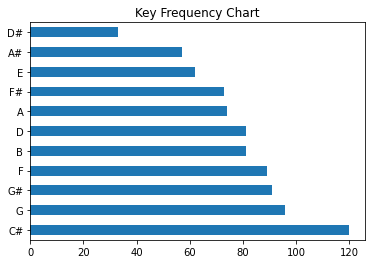

In [16]:
# The distribution of 'key' column after dropping the NA values
df_songs["key"].value_counts().plot.barh().set_title("Key Frequency Chart");

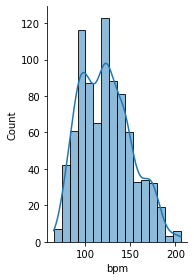

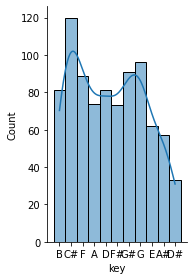

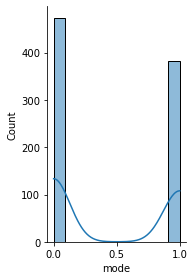

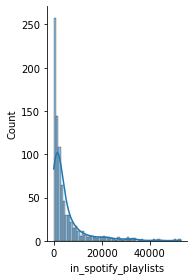

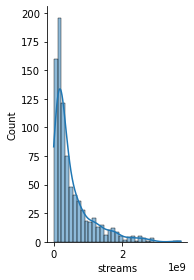

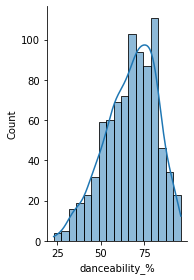

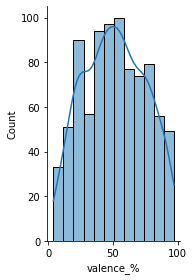

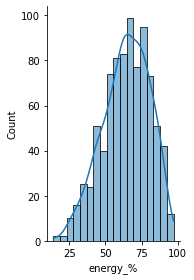

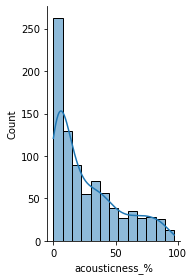

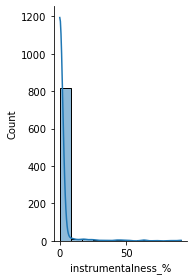

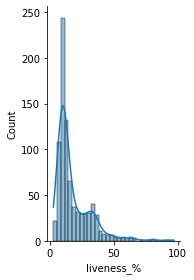

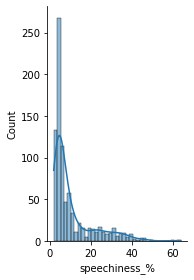

In [21]:
# 
features = ["bpm", "key", "mode" ,"in_spotify_playlists", "streams", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]
([sns.displot(df_songs[i], kde = True,height=4, aspect=.7) for i in features]);


### Data Cleaning Summary

- Converted columns to relevant data types to utilize for further analysis
- Deleted 95 rows where key column contained NA values. These values cannot be imputed as it is specific to each song. We also do not want to skew the results of the model.
- From examining the distribution plots of each feature, there are some features that have lot of outliers however we will have to work with them as our data size is small e.g streams, in_spotify_charts, instrumentalness_%, in_spotify_playlists. However, we can standardize the features if we are not happy with the accuracy.

In [19]:
df_clean = df_songs

## Exploratory Data Analysis

#### Correlation Matrix

From the correlation matrix, we notice there are few particular pairs of features that have a high correlation. The pairs of features with highest correlation are: 
- (streams, in_spotify_playlists) = 0.79
- (in_apple_playlists, streams) = 0.77
- (in_apple_playlist, in_spotify_playlist) = 0.71

When we are building our supervised learning model, we will keep these features in mind if we have to use subset of features instead as this may cause our model to overfit.

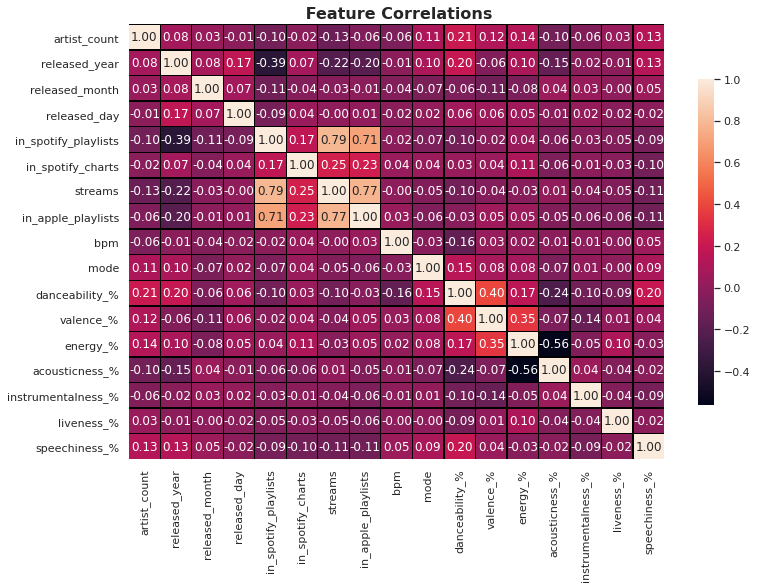

In [20]:
features = df_clean
c_m = features.corr()

plt.figure(figsize=(12, 8))
sns.set(style='white')
sns.heatmap(c_m, annot=True, fmt=".2f", linewidths=0.4, linecolor='black', cbar=True, cbar_kws={'shrink': 0.75})
plt.title(' Feature Correlations', fontsize=16, fontweight='bold')

plt.xticks(rotation=90)

plt.show()

#### Line Graph

The following graph also shows evidence that the energy and speechiness level tend to be high in songs found in Spotify charts.

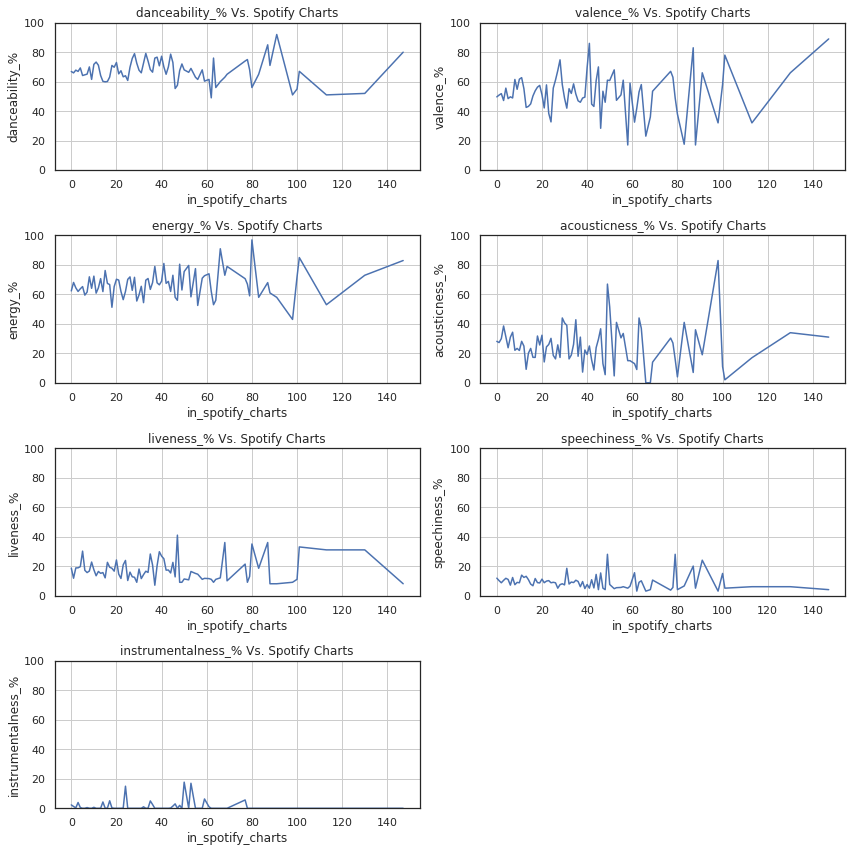

In [22]:
audio_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'liveness_%', 'speechiness_%', 'instrumentalness_%']
audio_features_by_year = df_clean.groupby('in_spotify_charts')[audio_features].mean().reset_index()


plt.figure(figsize=(12, 12))

for i, feature in enumerate(audio_features, start=1):
    plt.subplot(4, 2, i)  # 3 rows, 2 columns of subplots
    sns.lineplot(data=audio_features_by_year, x='in_spotify_charts', y=feature)
    plt.xlabel('in_spotify_charts')
    plt.ylabel(feature)
    plt.ylim(0,100)
    plt.title(f'{feature} Vs. Spotify Charts')
    plt.grid(True)

plt.tight_layout()
plt.show()

#### Data Imbalance

There is also an imbalance in the data as most of the values for in_spotify_charts is 0. This may make it difficult to predict values that are actually on the charts. 

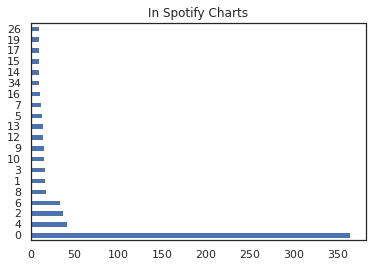

In [201]:
df_songs["in_spotify_charts"].value_counts().head(20).plot.barh().set_title("In Spotify Charts");

#### Trend over the years 

There has been a huge leap in number of songs released after year 2018. This may be as a result of increase in popularity of music streaming services and ease of access to music. Thus, motivating artists to release more music over time.

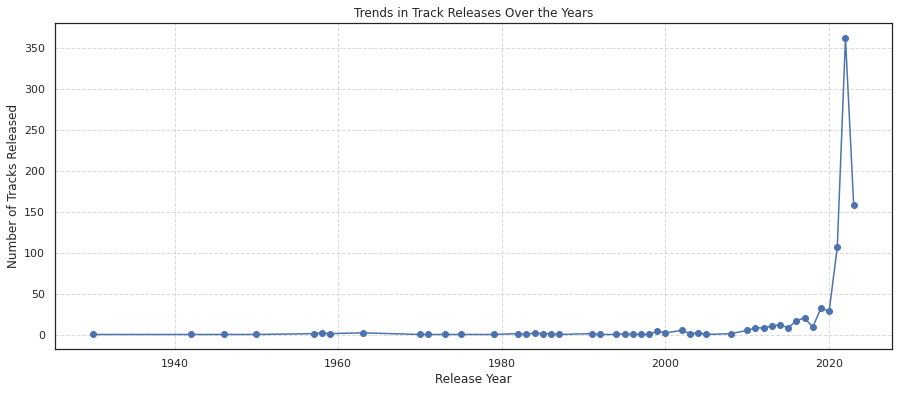

In [23]:
release_year_counts = df_clean['released_year'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
plt.plot(release_year_counts.index, release_year_counts.values, marker='o', linestyle='-')
plt.xlabel('Release Year')
plt.ylabel('Number of Tracks Released')
plt.title('Trends in Track Releases Over the Years')
plt.grid(True, linestyle='--', alpha=0.7)

In [24]:
df_clean['in_spotify_charts'].describe()

count    857.000000
mean      11.959160
std       19.194211
min        0.000000
25%        0.000000
50%        3.000000
75%       16.000000
max      147.000000
Name: in_spotify_charts, dtype: float64

### EDA Summary

- Based on the correlation matrix, there is evidence that in_spotify_playlist, in_apple_playlist, and number of streams are highly correlated and could cause issues with multicollinearity. When tuning our model, this information will help us to avoid overfitting our model and avoid difficulties building our model. We can decide to use only one of the variable if it helps.

- speechiness_%, streams, danceability, and energy_% are most significant features and explain the most variability of the target variable. This shows evidence that people tend to enjoy songs with lyrics, high energy levels, and something they can dance to. 

- We also must note that the target variable consists of integers only and ranges from 0 to 147 so a linear regression model may give some difficulties.

- A huge portion of the music was released after 2018. This could've been as a result of the huge development in music streaming services.

In [170]:
df_clean = df_songs

## Building Supervised Learning Models

### Feature Engineering

'Key' is a non-ordinal categorical variable so let's split it into multiple binary columns as it will be more efficient for our model. 

In [172]:
df_clean['key'].unique()

<StringArray>
['B', 'C#', 'F', 'A', 'D', 'F#', 'G#', 'G', 'E', 'A#', 'D#']
Length: 11, dtype: string

In [173]:
df_clean = pd.concat([df_clean, pd.get_dummies(df_clean['key'])], axis=1)
df_clean.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,A#,B,C#,D,D#,E,F,F#,G,G#
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,0,1,0,0,0,0,0,0,0,0
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,0,0,1,0,0,0,0,0,0,0
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,0,0,0,0,0,0,1,0,0,0
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,0,0,0,0,0,0,0,0,0,0
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,0,0,0,0,0,0,0,0,0,0


### Linear Regression

We will use linear regression to gain insights on the importance of features on our target variable, rank in in_spotify_charts. Although this is also a supervised learning model, it can give us some important information such as the significance of the predictors based on various statistical tests.

In [174]:
import statsmodels.api as sm

#### Feature importance

Based on the following regression results, we can observe that the released year, speechiness_%, streams, and energy_% are significant features at 5% significance level. These features give us the most information to predict the rank in Spotify charts. However, the other features that should have an impact on the target variable are not significant. We will need to scale or standardize these variables to get more accurate results. 

There is also strong evidence of multicollinearity as the condition number is large. The features that have the most collinearity are in_spotify_playlists and in_apple_playlists so we will only keep in_spotify_playlists as we are working with Spotify data.

In [175]:
df_clean.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,A#,B,C#,D,D#,E,F,F#,G,G#
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,0,1,0,0,0,0,0,0,0,0
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,0,0,1,0,0,0,0,0,0,0
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,0,0,0,0,0,0,1,0,0,0
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,0,0,0,0,0,0,0,0,0,0
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,0,0,0,0,0,0,0,0,0,0


There are few variables that very large values which may skew the model. We are going to log transform them to help us get more accurate results and reduce the non-constant variance.

In [177]:
df_clean['in_spotify_playlists'] = np.log2(df_clean['in_spotify_playlists'])
df_clean['in_apple_playlists'] = np.log2(df_clean['in_apple_playlists'])

In [178]:
df_clean['streams'] = np.log2(df_clean['streams'])

In [179]:
df_clean['in_spotify_charts'] = np.log2(df_clean['in_spotify_charts'])

In [180]:
# replace NaN and -inf values with 0
df_clean = df_clean.replace([np.nan, -np.inf], 0)

In [181]:
df_clean['in_spotify_charts'].describe()

count    857.000000
mean       2.069997
std        2.162823
min        0.000000
25%        0.000000
50%        1.584963
75%        4.000000
max        7.199672
Name: in_spotify_charts, dtype: float64

In [182]:
df_clean['in_spotify_playlists'].describe()

count    857.000000
mean      11.122075
std        1.931999
min        4.954196
25%        9.746514
50%       11.120238
75%       12.436191
max       15.690926
Name: in_spotify_playlists, dtype: float64

In [183]:
Y = df_clean['in_spotify_charts']
X = df_clean.drop(['in_spotify_charts','track_name','artist(s)_name','key'], axis=1)

X = sm.add_constant(X)
model = sm.OLS(Y,X)

results = model.fit()


print_model = results.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      in_spotify_charts   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     4.954
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           2.76e-14
Time:                        05:02:30   Log-Likelihood:                -1814.8
No. Observations:                 857   AIC:                             3684.
Df Residuals:                     830   BIC:                             3812.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -66.0495 

In [193]:
Y = df_clean['in_spotify_charts']
X = df_clean.drop(['in_spotify_charts','track_name','artist(s)_name','key','artist_count','released_year',
                  'released_month','released_day'], axis=1)

X = sm.add_constant(X)
model = sm.OLS(Y,X)

results = model.fit()
y_pred_lr = results.predict(X)

print_model = results.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      in_spotify_charts   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.670
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           1.42e-11
Time:                        05:05:55   Log-Likelihood:                -3697.9
No. Observations:                 857   AIC:                             7442.
Df Residuals:                     834   BIC:                             7551.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.5695 

### Split data into training and test

- Test size will be about 10% of the entire data or 86 rows
- Training size will have 771 rows

In [127]:
from sklearn.model_selection import train_test_split

In [185]:
df_clean = df_songs

In [186]:
# Test size will be about 10% of the entire data or 86 rows
# Training size will have 771 rows

Y = df_clean['in_spotify_charts']
X = df_clean.drop(['in_spotify_charts','track_name','artist(s)_name', 'in_apple_playlists','key',
                   'artist_count', 'released_month','released_day'], axis=1)

df_clean = pd.concat([df_clean, pd.get_dummies(df_clean['key'])], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

### Random Forest

In [187]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, recall_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder

In [188]:
# Initialize RandomForestRegressor with specified parameters
rf_model = RandomForestRegressor(n_estimators=100, max_depth=40, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics - Adjusted R-Squared, R-Squared, RMSE
r2 = r2_score(y_test, y_pred_rf)
adj_r2 = 1 - (1 - r2) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)

# Print the metrics
print(f"Adjusted R-Squared: {adj_r2:.4f}")
print(f"R-Squared: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

Adjusted R-Squared: 0.0587
R-Squared: 0.1916
RMSE: 16.34


### Gradient Boosting

In [145]:
from sklearn.model_selection import GridSearchCV

In [163]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    # Add other parameters to explore
}

# Initialize RandomForestRegressor
gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search for optimal hyperparameters
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gb_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_gb = best_gb_model.predict(X_test)

# Calculate metrics - Adjusted R-Squared, R-Squared, RMSE
r2 = r2_score(y_test, y_pred_gb)
adj_r2 = 1 - (1 - r2) * ((len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
rmse = mean_squared_error(y_test, y_pred_gb, squared=False)

# Print the metrics
print(f"Adjusted R-Squared: {adj_r2:.4f}")
print(f"R-Squared: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Adjusted R-Squared: 0.0301
R-Squared: 0.1671
RMSE: 16.59


### Lasso

In [41]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [42]:
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 12.730 (1.350)


## Results and Analysis

### Summary of Results

The Ordinary Least Square model performed decent with predicting new values based on the $R^2$ and adjusted $R^2$. I was able to improve the performance by reducing multicollinearity between variables and dropping some predictors. Also, some predictors such as audio features were log transformed to be in a similar case to reduce the volatility in the data however the accuracy did not improve much. There is clearly some non-linear relationship that the linear model is not able to handle.

The next best supervised learning model was Gradient boosting. It has a higher $R^2$ than linear regression but a low adjusted $R^2$. It also takes the longest to build as it is the most complex. Even after hypertuning the parameters and using the optimal values for the parameters, we weren't able to beat the Random Forest model. Thus, we cannot use this model to accurately make predictions. We also scaled the data to reduce volatility however it didn't improve much in performance.

The Random forest model is the best model in terms of accuracy for predictions. It has the highest $R^2$ and a positive adjusted $R^2$. There is clearly some non-linear relationship in the data and Random Forest can handle both types of relationships. The data also has non-constant variance which the Random forest model handles by averaging the results across the multiple decision trees it builds. From the predicted vs actual values plot, we can see that this model is closest to having a linear relationship between predicted and actual values.


In [165]:
print("Linear Regression: R^2 = 0.121, Adjusted R^2 = 0.1")
print("Random Forest: R^2 = 0.1916, Adjusted R^2 = 0.0587, RMSE = 16.34")
print("Gradient Boosting: R^2 = 0.1671, Adjust R^2 = 0.0301, RMSE = 16.59")

Linear Regression: R^2 = 0.121, Adjusted R^2 = 0.1
Random Forest: R^2 = 0.1916, Adjusted R^2 = 0.0587, RMSE = 16.34
Gradient Boosting: R^2 = 0.1671, Adjust R^2 = 0.0301, RMSE = 16.59


From observing the following graphs of predict vs. actual values, we can see that the graph does not have a linear pattern. This maybe due to the imbalance in the data and tells us that the variance is not constant which breaks one of the main assumptions of the linear model.

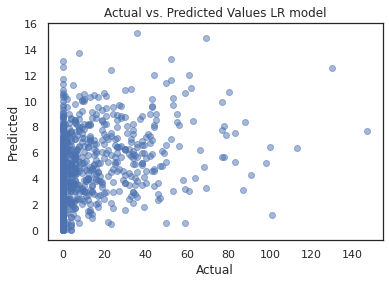

In [192]:
# Plotting actual vs. predicted values for Linear Regression
plt.scatter(Y, np.power(y_pred_lr,2), alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values LR model')
plt.show()

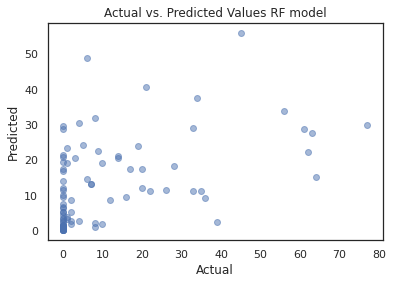

In [189]:
# Plotting actual vs. predicted values for Random Forest
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values RF model')
plt.show()

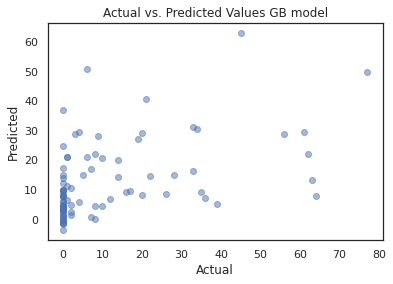

In [169]:
# Plotting actual vs. predicted values for Gradient Boosting
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values GB model')
plt.show()

## Conclusion

We were given data on most famous songs on Spotify in 2023. After doing analysis and predictive modelling, we came to a conclusion that the features of a song such as speechiness_%, danceability_%, streams, and energy_% play a big role in determining the ranks of a song in the chart. Music listeners tend to enjoy lyrics and high energy level songs which something they can dance to. 

The songs data has evidence of non-linear relationships which makes it a challenge for predicitivy as we have to use more complex models. The numerical ranges of the features also vary a lot which skewed some of the models we tried building. There was also an imbalance of the data as the ranking of most of songs were in rank 0, or were not in the charts, while we are given a range of upto 147. We also had to drop some rows as there were lot of NA values which are specific to a song and could not have been imputed without listening to all of the songs. 

In order to improve the predictivity of a song ranking in the charts, we can analyze songs across multiple years instead of only 2023. This will give us more data which will help to reduce the imbalance in the data. We could also scale the entire training data to reduce heteroskadascity in the data. If given more time, we could have also done some hyperparameter tuning by trying various values for max depth and estimators to find the optimal values. With more computational power, we can try more complex models such as XGBoost or Neural Networks to help us predict this non-linear relationship more accurately. 